In [1]:
!pip install matplotlib
import glob
import math

import torch

import kaolin as kal
import nvdiffrast
from matplotlib import pyplot as plt
glctx = nvdiffrast.torch.RasterizeGLContext(False, device='cuda')

## Load Mesh information

In [2]:
# Here replace the "root" by the path where you are storing shapenet
ds = kal.io.shapenet.ShapeNetV2(root='/mnt/data/ci_shapenetv2/', categories=['car'],
                                train=True, split=1., with_materials=True)

# Normalize the data between [-0.5, 0.5]
mesh = ds[0].data
vertices = mesh.vertices.unsqueeze(0).cuda()
vertices_min = vertices.min(dim=1, keepdims=True)[0]
vertices_max = vertices.max(dim=1, keepdims=True)[0]
vertices -= (vertices_max + vertices_min) / 2.
vertices /= (vertices_max - vertices_min).max()
faces = mesh.faces.cuda()

# Here we are preprocessing the materials, assigning faces to materials and
# using single diffuse color as backup when map doesn't exist (and face_uvs_idx == -1)
uvs = torch.nn.functional.pad(mesh.uvs.unsqueeze(0).cuda(), (0, 0, 0, 1))
face_uvs_idx = mesh.face_uvs_idx.cuda()
materials_order = mesh.materials_order
materials = [m['map_Kd'].permute(2, 0, 1).unsqueeze(0).cuda().float() / 255. if 'map_Kd' in m else
             m['Kd'].reshape(1, 3, 1, 1).cuda()
             for m in mesh.materials]

nb_faces = faces.shape[0]

num_consecutive_materials = \
    torch.cat([
        materials_order[1:, 1],
        torch.LongTensor([nb_faces])
    ], dim=0)- materials_order[:, 1]

face_material_idx = kal.ops.batch.tile_to_packed(
    materials_order[:, 0],
    num_consecutive_materials
).cuda().squeeze(-1)
mask = face_uvs_idx == -1
face_uvs_idx[mask] = 0
face_uvs = kal.ops.mesh.index_vertices_by_faces(
    uvs, face_uvs_idx
)
face_uvs[:, mask] = 0.

## Instantiate a camera

With the general constructor `Camera.from_args()` the underlying constructors are `CameraExtrinsics.from_lookat()` and `PinholeIntrinsics.from_fov`

In [3]:
cam = kal.render.camera.Camera.from_args(eye=torch.tensor([2., 0., 0.]),
                                         at=torch.tensor([0., 0., 0.]),
                                         up=torch.tensor([0., 1., 0.]),
                                         fov=math.pi * 45 / 180,
                                         width=512, height=512, device='cuda')

## Rendering a mesh

Here we are rendering the loaded mesh with [nvdiffrast](https://github.com/NVlabs/nvdiffrast) using the camera object created above

In [4]:
def render():
    transformed_vertices = cam.transform(vertices)
    # Create a fake W (See nvdiffrast documentation)
    pos = torch.nn.functional.pad(
        transformed_vertices, (0, 1), mode='constant', value=1.
    ).contiguous()
    rast = nvdiffrast.torch.rasterize(glctx, pos, faces.int(), (512, 512), grad_db=False)
    hard_mask = rast[0][:, :, :, -1:] != 0
    face_idx = (rast[0][..., -1].long() - 1).contiguous()

    uv_map = nvdiffrast.torch.interpolate(uvs, rast[0], face_uvs_idx.int())[0]
    uv_map = torch.clamp(uv_map, 0., 1.)

    img = torch.zeros((1, 512, 512, 3), dtype=torch.float, device='cuda')

    # Obj meshes can be composed of multiple materials
    # so at rendering we need to interpolate from corresponding materials
    im_material_idx = face_material_idx[face_idx]
    im_material_idx[face_idx == -1] = -1

    for i, material in enumerate(materials):
        mask = im_material_idx == i
        mask_idx = torch.nonzero(mask, as_tuple=False)
        _texcoords = uv_map[mask] * 2. - 1.
        _texcoords[:, 1] = -_texcoords[:, 1]
        pixel_val = torch.nn.functional.grid_sample(
            materials[i], _texcoords.reshape(1, 1, -1, 2),
            mode='bilinear', align_corners=False,
            padding_mode='border')
        img[mask] = pixel_val[0, :, 0].permute(1, 0)
    
    # Need to flip the image becasue opengl
    return torch.flip(torch.clamp(img * hard_mask, 0., 1.)[0], dims=(0,))

# Moving the camera

Once the camera is created you can move it using `cam.move_up()`, `cam.move_right` and `cam.move_forward()`.

To be noted that in OpenGL `forward` in the camera space is actually toward the viewer (so it actually move away from the object looked at)

<img src="./assets/ndc_camera_space.png"
     alt="Markdown Monster icon"
     style="float:left;margin-right:10px;width:400px" />
<img src="./assets/ndc_image_space.png"
     alt="Markdown Monster icon"
     style="float:left;margin-right:10px;width:300px" />

Below is a simple interactive rendering, where buttons are linked to camera methods for moving it.

<IPython.core.display.Javascript object>


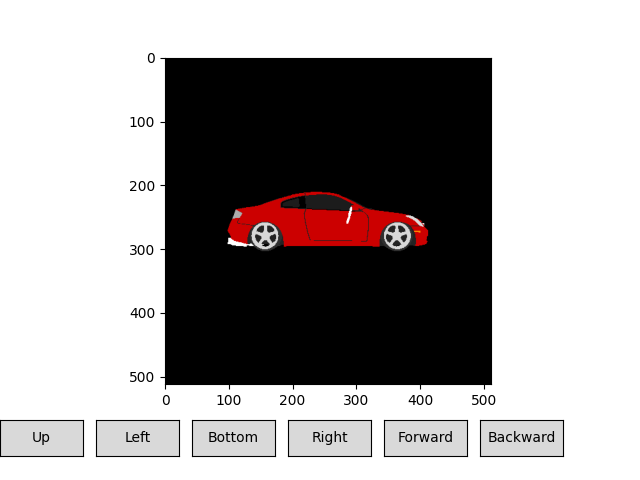

0

In [5]:
try:
    ipy_str = str(type(get_ipython()))
    if 'zmqshell' in ipy_str:
        %matplotlib notebook
finally:
    pass

from matplotlib.widgets import Button

fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.2)
im_buffer = plt.imshow(render().cpu())

def update():
    """Update the image buffer"""
    im_buffer.set_data(render().cpu())
    plt.draw()

def on_button_up_clicked(b):
    """Callback on Up"""
    cam.move_up(0.1)
    update()

def on_button_down_clicked(b):
    """Callback on Down"""
    cam.move_up(-0.1)
    update()

def on_button_left_clicked(b):
    """Callback on Left"""
    cam.move_right(-0.1)
    update()

def on_button_right_clicked(b):
    """Callback on Right"""
    cam.move_right(0.1)
    update()

def on_button_forward_clicked(b):
    """Callback on Forward
    
    Note: Forward is actually on the back of the camera
    """
    cam.move_forward(0.1)
    update()
    
def on_button_backward_clicked(b):
    """Callback on Backward
    
    Note: Forward is actually on the back of the camera
    """
    cam.move_forward(-0.1)
    update()

up_ax = plt.axes([0.0, 0.05, 0.13, 0.075])
left_ax = plt.axes([0.15, 0.05, 0.13, 0.075])
down_ax = plt.axes([0.3, 0.05, 0.13, 0.075])
right_ax = plt.axes([0.45, 0.05, 0.13, 0.075])
forward_ax = plt.axes([0.6, 0.05, 0.13, 0.075])
backward_ax = plt.axes([0.75, 0.05, 0.13, 0.075])
button_up = Button(up_ax, "Up")
button_down = Button(down_ax, "Bottom")
button_left = Button(left_ax, "Left")
button_right = Button(right_ax, "Right")
button_forward = Button(forward_ax, "Forward")
button_backward = Button(backward_ax, "Backward")
button_up.on_clicked(on_button_up_clicked)
button_down.on_clicked(on_button_down_clicked)
button_left.on_clicked(on_button_left_clicked)
button_right.on_clicked(on_button_right_clicked)
button_forward.on_clicked(on_button_forward_clicked)
button_backward.on_clicked(on_button_backward_clicked)
